# [Bonus Tasks](svm_segm.ipynb)

In [196]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as ndi
import skimage.morphology as morph
import skimage.util 
from skimage.util import view_as_windows
from skimage.filters import threshold_otsu
from skimage.util import view_as_blocks
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [197]:
def blend_result(img, seg, border_radius=1, interior_opacity=1, interior_opacity_decay=0.9, color=(0,1,0)):
    img  = np.dstack([img] * 3).copy()
    img -= img.min()
    img /= img.max()
    selem  = morph.disk(border_radius)
    seg_bd = np.logical_xor(morph.binary_dilation(seg, selem), morph.binary_erosion(seg, selem))
    mask_decay = ndi.distance_transform_edt(seg)
    for i in range(3):
        opacity = interior_opacity / pow(1 + mask_decay[seg], interior_opacity_decay)
        img[:,:,i][seg] = color[i] * opacity + (1 - opacity) * img[:,:,i][seg]
        img[:,:,i][seg_bd] = color[i]
    return img

In [198]:
patch_sizes = (32, 32)

---

**[Task 1.1.]()** Implement `create_data_matrix`:

In [199]:
def create_data_matrix(img):
    blocks = view_as_blocks(img, block_shape=patch_sizes)

    patches = blocks.reshape(-1, patch_sizes[0], patch_sizes[1]) # -1 zählt automatisch die Anzahl der Patches

    X = patches.reshape(patches.shape[0], -1) # -1 multipliziert 32 und 32 zu 1024
    return X # ergebnis ist eine Matrix mit der Form (Anzahl der Patches, 1024)
    



**[Task 1.2.]()** Implement `create_gt_labels_vector`:

In [200]:
def create_labels_vector(gt_image):

    blocks = view_as_blocks(gt_image, block_shape=patch_sizes)

    patches = blocks.reshape(-1, patch_sizes[0], patch_sizes[1]) # -1 zählt automatisch die Anzahl der Patches

    num_patches = patches.shape[0]
    

    y = np.zeros(num_patches, dtype=int)

    patch_area = patch_sizes[0] * patch_sizes[1]

    for i in range(num_patches):
        patch = patches[i]
        fg = np.sum(patch) 
        fg_prozent = fg / patch_area

        if fg_prozent > 0.5: # mehr als 50% Vordergrund
            y[i] = 1
        elif fg_prozent == 0 : #kein Vordergrund
            y[i] = -1
        else:
            y[i] = 0 # mehr als 0% und weniger als 50% Vordergrund

    return y



**[Task 1.3.]()** Create the SVM classifier:

In [201]:
clf = make_pipeline(StandardScaler(), SVC(class_weight='balanced', gamma=0.1))

**[Task 1.3 (a).]()** Create the data matrices for the images `dna-33` and `dna-44`:

In [202]:
dna_33 = plt.imread("data/NIH3T3/im/dna-33.png")
dna_44 = plt.imread("data/NIH3T3/im/dna-44.png")


M_33 = create_data_matrix(dna_33)
M_44 = create_data_matrix(dna_44)


**[Task 1.3 (b).]()** Create the corresponding ground truth label vectors:

In [203]:
gt_33 = plt.imread("data/NIH3T3/gt/33.png") 
gt_44 = plt.imread("data/NIH3T3/gt/44.png")

gt_M_33 = create_labels_vector(gt_33)
gt_M_44 = create_labels_vector(gt_44)   


**[Task 1.3 (c).]()** Create the *combined* data matrices and ground truth label vectors:

In [204]:
mask_33 = (gt_M_33 != 0) # boolean maske, die alle patches mit label -1 ausschließt
mask_44 = (gt_M_44 != 0)

M_33_True = M_33[mask_33] # nur die patches, die in der maske True sind
M_44_True = M_44[mask_44]

gt_M_33_True = gt_M_33[mask_33]
gt_M_44_True = gt_M_44[mask_44]

m_combined = np.concatenate((M_33_True, M_44_True), axis=0)
gt_combined = np.concatenate((gt_M_33_True, gt_M_44_True), axis=0)

print("Combined data matrix shape:", m_combined.shape)
print("Combined labels vector shape: " + str(gt_combined.shape) + 
      "\nAnzahl der Patches: " + str(gt_combined.shape[0]) + 
      "\nPixel pro Patch: " + str(patch_sizes[0] * patch_sizes[1]))



Combined data matrix shape: (2109, 1024)
Combined labels vector shape: (2109,)
Anzahl der Patches: 2109
Pixel pro Patch: 1024


**[Task 1.3 (d).]()** Train the classifier using the data matrix and label vectors from above:

In [205]:
clf.fit(m_combined, gt_combined)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', gamma=0.1))])

**[Task 1.4.]()** Implement the function `predict_image`:

In [206]:
def predict_image(img):
    blocks = view_as_blocks(img, block_shape=patch_sizes)
    patches = blocks.reshape(-1, patch_sizes[0], patch_sizes[1])
    X = patches.reshape(patches.shape[0], -1)

    predicted_labels = clf.predict(X)

    binary_result = np.zeros((img.shape[0], img.shape[1]), dtype=bool)

    patch_height, patch_width = patch_sizes
    idx = 0
    for i in range(0, img.shape[0], patch_height):
        for j in range(0, img.shape[1], patch_width):
            if predicted_labels[idx] == 1:
                binary_result[i:i+patch_height, j:j+patch_width] = True
            idx = idx + 1

    return binary_result

Test your implementation:

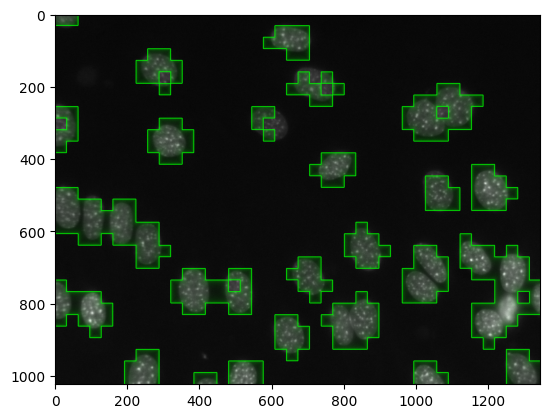

In [207]:
img = plt.imread(f'data/NIH3T3/im/dna-0.png')
seg = predict_image(img)

plt.figure()
plt.imshow(blend_result(img, seg))

**[Task 1.5.]()** Perform batch processing:

**[Task 2.1.]()** Overlapping patches: